# Normality of bootstrap samples


In [1]:
%load_ext autoreload

In [2]:
%autoreload 2


In [3]:
import sys
sys.path.append('/home/ssm-user/Github/memento')

In [4]:
import scanpy as sc
import scipy.stats as stats
import scipy.sparse as sparse
import pandas as pd
import numpy as np
import string
import random
import logging
import itertools
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import random
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from pymare import core, estimators


In [5]:
import memento

In [6]:
import memento.model.rna as rna
import memento.estimator.hypergeometric as hg

In [7]:
data_path = '/data_volume/memento/'

In [8]:
logging.basicConfig(
    format="%(asctime)s %(process)-7s %(levelname)-8s %(message)s",
    level=logging.INFO, 
    datefmt="%Y-%m-%d %H:%M:%S",
)
logging.captureWarnings(True)

### Set up AnnData and memento

In [9]:
adata = sc.read(data_path + 'hbec/HBEC_type_I_filtered_counts_deep.h5ad')
adata.obs['q'] = 0.07
rna.MementoRNA.setup_anndata(
    adata=adata,
    q_column='q',
    label_columns=['donor', 'stim'],
    num_bins=30)

# Define expressed genes
adata.var['expr_genes'] = (adata.X.mean(axis=0).A1 > 0.02)
adata = adata[:, adata.var['expr_genes']]



model = rna.MementoRNA(adata=adata)

2023-07-03 11:47:35 3021607 INFO     setup_anndata: creating groups
2023-07-03 11:47:35 3021607 INFO     setup_anndata: computing cell sizes


### Check non-normal genes for mean

In [69]:
group = 'memento_group^d2513^alpha'
barcodes = adata.uns['memento']['group_barcodes'][group]
gene_list = adata.var.index.tolist()

data = model.subset_matrix(barcodes, gene_list).tocsc() #CSC format is faster
sf = model.adata.obs.loc[barcodes]['memento_size_factor'].values
approx_sf = model.adata.obs.loc[barcodes]['memento_approx_size_factor'].values
q = model.adata.uns['memento']['group_q'][group]

n_boot = 10000

In [ ]:
ks_pv_list = []

for idx, gene in enumerate(gene_list):
    
    samples = hg.hg_sem_for_gene(
        X=data[:, idx],
        q=q,
        approx_size_factor=approx_sf,
        num_boot=n_boot,
        group_name=group, 
        return_boot_samples=True)
    samples = np.log(samples)
    ks_pv = stats.kstest(samples, 'norm', args=(samples.mean(), samples.std()))[1]
    ks_pv_list.append(ks_pv)

In [88]:
ks_pv_list = np.array(ks_pv_list)

<Axes: ylabel='Density'>

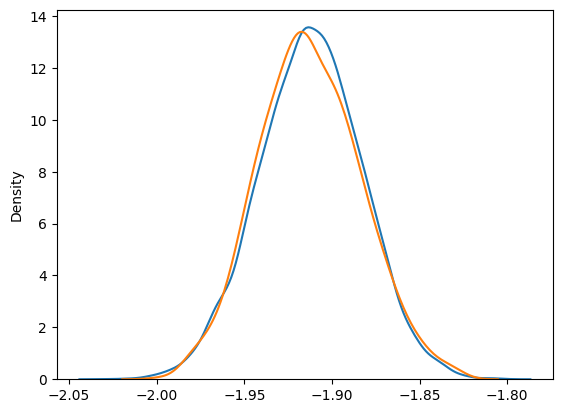

In [89]:
sns.kdeplot(samples)
sns.kdeplot(stats.norm.rvs(samples.mean(), samples.std(), size=1000))

In [95]:
print('proportion of non-normal mean bootstrap genes at alpha < 0.05', (ks_pv_list < 0.05).mean())

proportion of non-normal mean bootstrap genes at alpha < 0.05 0.05555555555555555


### Normality of variance estimator

In [184]:
group = 'memento_group^d2513^alpha'
barcodes = adata.uns['memento']['group_barcodes'][group]
gene_list = adata.var.index.tolist()

data = model.subset_matrix(barcodes, gene_list).tocsc() #CSC format is faster
sf = model.adata.obs.loc[barcodes]['memento_size_factor'].values
approx_sf = model.adata.obs.loc[barcodes]['memento_approx_size_factor'].values
q = model.adata.uns['memento']['group_q'][group]

n_boot = 500

In [185]:
model.compute_estimate(
    estimand='var',
    get_se=False,
    verbose=1,
    n_jobs=30,
)

2023-07-03 13:22:15 3021607 INFO     compute_estimate: running estimators for ['var', 'log_var', 'resvar', 'log_resvar', 'total_umi', 'cell_count', 'total_umi', 'cell_count', 'total_umi', 'cell_count', 'total_umi', 'cell_count', 'total_umi', 'cell_count', 'total_umi', 'cell_count']
2023-07-03 13:22:15 3021607 INFO     compute_estimate: gene_list is None, using all genes in AnnData object
2023-07-03 13:22:15 3021607 INFO     compute_estimate: getting estimates for memento_group^d2513^lambda using 30 parallel jobs
2023-07-03 13:22:15 3021607 INFO     compute_estimate: getting estimates for memento_group^d2513^alpha using 30 parallel jobs
2023-07-03 13:22:16 3021607 INFO     compute_estimate: getting estimates for memento_group^d2614^alpha using 30 parallel jobs
2023-07-03 13:22:16 3021607 INFO     compute_estimate: getting estimates for memento_group^d2614^gamma using 30 parallel jobs
2023-07-03 13:22:17 3021607 INFO     compute_estimate: getting estimates for memento_group^d2513^beta us

In [193]:
hg.hg_sev_for_gene(
        X=data[:, idx],
        q=q,
        approx_size_factor=approx_sf,
        mv_fit=model.mv_regressors[group],
        num_boot=n_boot,
        group_name=group, 
        return_boot_samples=True)

(nan, nan, nan, nan)

In [194]:
random_sample = np.random.choice(len(gene_list), 1000)
ks_pv_list = []

for idx, gene in enumerate(gene_list):
    
    if idx not in random_sample:
        continue
    var_samples, resvar_samples = hg.hg_sev_for_gene(
        X=data[:, idx],
        q=q,
        approx_size_factor=approx_sf,
        mv_fit=model.mv_regressors[group],
        num_boot=n_boot,
        group_name=group, 
        return_boot_samples=True)
    resvar_samples = np.log(resvar_samples)
    resvar_samples=resvar_samples[np.isfinite(resvar_samples)]
    ks_pv = stats.kstest(resvar_samples, stats.norm.cdf, args=(stats.norm.fit(resvar_samples)))[1]
    ks_pv_list.append(ks_pv)
ks_pv_list = np.array(ks_pv_list)

In [195]:
print('proportion of non-normal log-residual variance bootstrap genes at alpha < 0.05', (ks_pv_list < 0.05).mean())

proportion of non-normal log-residual variance bootstrap genes at alpha < 0.05 0.06921487603305786


In [196]:
print('proportion of non-normal log-variance bootstrap genes at alpha < 0.05', (ks_pv_list < 0.05).mean())

proportion of non-normal log-variance bootstrap genes at alpha < 0.05 0.06921487603305786
